### Load Packages

In [2]:
import argparse
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from eval import ToTensor, Normalize
from model import EventDetector
from test_video import SampleVideo
import torch.nn.functional as F
import sys
import numpy as np
from moviepy.editor import ImageSequenceClip
import matplotlib.pyplot as plt

### Initialize Parameters

In [4]:
# "Path to video that you want to test"
video_path = "/Users/rokbohinc/Documents/Work/Golf_AI/Golfshot_Categoriser/data/raw/Videos/1575B739-F5FD-4F2D-9B81-8EBEAC2875712024-04-16/Shot13.mp4"

# Path to the model
model_path = "models/swingnet_2000.pth.tar"

# Number of frames to use per forward pass
seq_length = 64

### Initialize Data Set

In [24]:
def init_data(video_path):
    ds = SampleVideo(
        path = video_path,
        transform = transforms.Compose(
            [ToTensor(), Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
        )
    )

    dl = DataLoader(dataset=ds, 
                    batch_size=1, 
                    shuffle=False, 
                    drop_last=False)
    
    return(dl)

In [25]:
dl = init_data(video_path)

### Inicialize Model

In [9]:
def init_model(modelpath):
    model = EventDetector(
        pretrain=True,
        width_mult=1.0,
        lstm_layers=1,
        lstm_hidden=256,
        bidirectional=True,
        dropout=False)

    model.load_state_dict(torch.load(modelpath)["model_state_dict"])
    model.to(torch.device("cpu"))
    model.eval()
    return(model)

In [10]:
model = init_model(modelpath = model_path)

### Calculate Probabilities

In [11]:
def calc_probs(dl, model, seq_length):
    probs = []  
    for sample in dl:
        images = sample["images"]
        batch = 0
        # full samples do not fit into GPU memory so evaluate sample in 'seq_length' batches
        while batch * seq_length < images.shape[1]:
            if (batch + 1) * seq_length > images.shape[1]:
                image_batch = images[:, batch * seq_length :, :, :, :]
            else:
                image_batch = images[
                    :, batch * seq_length : (batch + 1) * seq_length, :, :, :
                ]
            logits = model(image_batch)

            if batch == 0:
                probs = F.softmax(logits.data, dim=1).cpu().numpy()
            else:
                probs = np.append(probs, F.softmax(logits.data, dim=1).cpu().numpy(), 0)
            batch += 1
    return(probs)

In [12]:
probs = calc_probs(dl, model, seq_length)

### Determining Key Frames/Events

In [13]:
def get_cron_events(probs):
    cron_events = []
    event = 0
    for i in range(0, probs.shape[1]-1):
        event = event + np.argmax(probs[event:,i])
        cron_events.append(event)

    return(cron_events)

def get_event_prob(probs, events):
    confidence = []
    for i, e in enumerate(events):
        confidence.append(round(probs[e, i] * 100))

    return(confidence)


In [14]:
event_names = ["Address", "Toe-up", "Mid-backswing", "Top", "Mid-downswing", "Impact", "Mid-follow-through", "Finish"]

In [88]:
classic_events = np.argmax(probs, axis=0)[:-1]
classic_probs = get_event_prob(probs, classic_events)
classic_Events = list(zip(event_names, classic_events, classic_probs))

In [89]:
classic_Events

[('Address', 88, 4),
 ('Toe-up', 102, 23),
 ('Mid-backswing', 106, 93),
 ('Top', 121, 51),
 ('Mid-downswing', 125, 91),
 ('Impact', 129, 19),
 ('Mid-follow-through', 131, 55),
 ('Finish', 91, 18)]

In [15]:
cron_events = get_cron_events(probs)
cron_probs = get_event_prob(probs, cron_events)
cron_Events = list(zip(event_names, cron_events, cron_probs))

In [16]:
cron_Events

[('Address', 88, 4),
 ('Toe-up', 102, 23),
 ('Mid-backswing', 106, 93),
 ('Top', 121, 51),
 ('Mid-downswing', 125, 91),
 ('Impact', 129, 19),
 ('Mid-follow-through', 131, 55),
 ('Finish', 148, 15)]

## Show Figures

In [17]:
def display_nth_frame(cap, n):
    """
    Displays the n-th frame of a video using an existing VideoCapture object.

    Parameters:
    cap (cv2.VideoCapture): An already created VideoCapture object.
    n (int): Frame index to display (0-based indexing).

    Returns:
    None
    """
    # Check if video capture object was successfully opened
    if not cap.isOpened():
        print("Error: Video capture not open.")
        return

    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, n)

    # Read the frame
    ret, frame = cap.read()
    if ret:
        # Convert the image from BGR to RGB (OpenCV uses BGR by default)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Display the frame using matplotlib
        plt.imshow(frame_rgb)
        plt.title(f"Frame {n}")
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.show()
    else:
        print(f"Error: Could not read the frame at index {n}.")

# Example of how to use this function:
# First, create a VideoCapture object:
# cap = cv2.VideoCapture('path_to_your_video.mp4')
# Then call the function with the desired frame number:
# display_nth_frame(cap, 10)
# Don't forget to release the capture object when done:
# cap.release()

In [18]:
def display_frames_with_annotations(cap, events):
    """
    Displays specified frames of a video side by side with their associated labels and probabilities using an existing VideoCapture object. Each subplot will have the label and frame index as the title, and the probability displayed at the bottom of the figure.

    Parameters:
    cap (cv2.VideoCapture): An already created VideoCapture object.
    events (list of tuples): List of tuples where each tuple contains a label, a frame index, and a probability.

    Returns:
    None
    """
    # Check if video capture object was successfully opened
    if not cap.isOpened():
        print("Error: Video capture not open.")
        return

    # Set up the subplot dimensions
    num_frames = len(events)
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))  # Adjust figsize as needed

    # Loop through each tuple in the events list and process the frames
    for i, (label, frame_index, probability) in enumerate(events):
        # Set the frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

        # Read the frame
        ret, frame = cap.read()
        if ret:
            # Convert the image from BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Display the frame on its subplot
            if num_frames > 1:
                axes[i].imshow(frame_rgb)
                axes[i].set_title(f"{label} ({frame_index})", fontsize=10)
                axes[i].text(0.5, 0.05, f"Prob: {probability}%", fontsize=8, color='black', transform=axes[i].transAxes, ha='center')
                axes[i].axis('off')  # Turn off axis numbers and ticks
            else:
                axes.imshow(frame_rgb)
                axes.set_title(f"{label} (Frame {frame_index})", fontsize=10)
                axes.set_xlabel(f"Prob: {probability}%", fontsize=8)
                axes.axis('off')  # Useful for a single frame scenario

    # Show all the frames together
    plt.show()

# Example usage:
# cap = cv2.VideoCapture('path_to_your_video.mp4')
# events = [('Address', 88, 4),
#           ('Toe-up', 102, 23),
#           ('Mid-backswing', 106, 93),
#           ('Top', 121, 51),
#           ('Mid-downswing', 125, 91),
#           ('Impact', 129, 19),
#           ('Mid-follow-through', 131, 55),
#           ('Finish', 91, 18)]  # Example labels, frame indices, and probabilities
# display_frames_with_annotations(cap, events)
# cap.release()


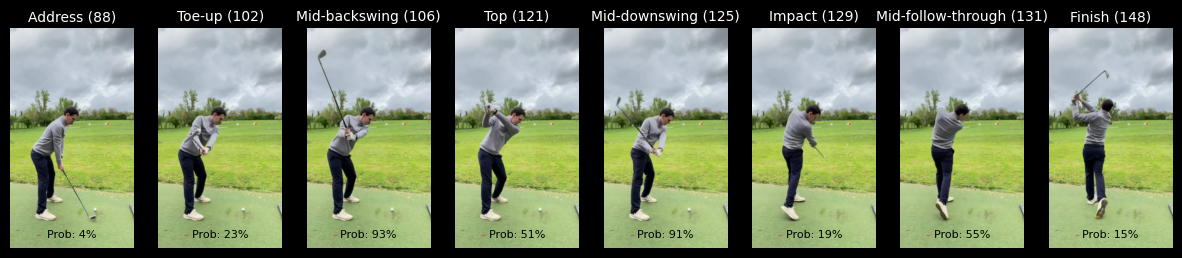

In [19]:
cap = cv2.VideoCapture(video_path)
display_frames_with_annotations(cap, cron_Events)

### Create a mp4 video

In [20]:
def copmpose_frames(cap, events):
    """
    Save key frames of the golf shot into a list of rgb object

    Parameters:
    cap (cv2.VideoCapture): An already created VideoCapture object.
    events (list of tuples): List of tuples where each tuple contains a label, a frame index, and a probability.

    Returns:
    List of rgb objects
    """
    # Check if video capture object was successfully opened
    if not cap.isOpened():
        print("Error: Video capture not open.")
        return

    frames = []
    # Loop through each tuple in the events list and process the frames
    for i, (label, frame_index, probability) in enumerate(events):
        # Set the frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

        # Read the frame
        ret, frame = cap.read()
        if ret:
            # Convert the image from BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
        else:
            print(f"Failed to retrieve frame at index {frame_index}")

    return(frames)

In [21]:
frames = copmpose_frames(cap, cron_Events)

In [22]:
# Create a video clip from the extracted frames, specify the FPS
clip = ImageSequenceClip(frames, fps=4)  # You can adjust FPS to your preference

# Write the video file to disk
clip.write_videofile('output_video.mp4', codec='libx264')


Moviepy - Building video output_video.mp4.
Moviepy - Writing video output_video.mp4



Moviepy - Done !
Moviepy - video ready output_video.mp4
